# Bonus

## Google Collab mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [2]:
%cd drive/"My Drive"/ECSE-415-Project/Submission

/content/drive/My Drive/ECSE-415-Project/Submission


## Library imports

In [3]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16
import pickle
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

## Dataset Extraction

In [0]:
train_x = np.asarray(pd.read_csv("train_x.csv",header=None))
train_x = train_x.reshape(-1,256,256,3)

In [0]:
bbox_train = pickle.load( open("bbox_train.pickle", 'rb'))

In [0]:
def preprocess(img, pad=0):
  img = img.astype("uint8")
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  return img

In [0]:
def crop(idx,img):
  x,y,w,h = bbox_train[idx]

  return img[y:y+h, x:x+w]

In [0]:
train_x_preprocessed = [crop(i,preprocess(img,pad=0)) for i,img in enumerate(train_x)]



# Object Detection
## Training
### Resize the training images to 128 × 128. 


In [0]:
df_car = pd.DataFrame({"grayscale":train_x_preprocessed })

# Resize each training image to 128 X 128
df_car["resized"] = df_car["grayscale"].apply(lambda img: cv2.resize(img,(128,128)),1)

### Compute HoG features using cell size of 5 × 5 pixels, block size of 2 × 2 cells and 9 orientation bins 

In [0]:
def hog_features(img_grayscale,cell_size, block_size, nbins):
    """Compute HoG features 
    img_grayscale: grayscale NumPy array representing iamge
    cell_size: tupple of (height,width) in pixels
    block_size: tupple of (height,width) in cells
    nbins: # number of orientation bins
    
    Return HoG features
    
    """
    # create HoG Object
    hog = cv2.HOGDescriptor(_winSize=(img_grayscale.shape[1] // cell_size[1] * cell_size[1],
                                      img_grayscale.shape[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)


    # Compute HoG features
    n_cells = (img_grayscale.shape[0] // cell_size[0], img_grayscale.shape[1] // cell_size[1])
    hog_features = hog.compute(img_grayscale)
    
    
    # Reshape HoG features as specified by tutorial 5
    hog_features =hog_features.reshape(n_cells[1] - block_size[1] + 1,
                            n_cells[0] - block_size[0] + 1,block_size[1], 
                                       block_size[0], nbins) \
                   .transpose((1, 0, 3, 2, 4))  

    
    return hog_features

# HoG Features for each 128 x 128 rescaled car grayscale image
df_car["hog"] = df_car["resized"].apply(lambda img: hog_features(img,cell_size = (5, 5), 
                                                                 block_size = (2,2), nbins = 9),1)

### Calculate and store the mean feature map across training images.

In [0]:
mean_feature_map = np.sum(df_car["hog"])/(df_car["hog"].shape[0])

### Repeat above steps for training images flipped around vertical axis.

In [0]:
# Flip around vertical axis
df_car["flipped"] = df_car["grayscale"].apply(lambda img: cv2.flip(img,1))

# Resize image to 128 x 128
df_car["flipped_and_resized"] = df_car["flipped"].apply(lambda img: cv2.resize(img,(128,128)),1)
                                              
# Hog features                                            
df_car["hog_flipped"] = df_car["flipped_and_resized"].apply(lambda img: hog_features(img,cell_size = (5, 5), 
                                                                         block_size = (2,2), nbins = 9),1)

# Mean feature map
mean_feature_map_flipped = np.sum(df_car["hog_flipped"])/(df_car["hog_flipped"].shape[0])

## Testing
### Extract overlapping windows from the test image. Details on the size of the window and the stride are given below. 

In [0]:
# Read test image in grayscale
img_test = cv2.imread("Images/Group_pic_1.JPG",0)
img_test = cv2.resize(img_test, (int(img_test.shape[1]/2),int(img_test.shape[0]/2)))

def extract_overlapping_windows(grayscale_img,
                                window_size,step_size):
    """Extract overlapping windows from img
    
    grayscale_img: 2D NumPy array representing grayscale image
    window_size: (height, width) of window
    step_size: by how many pixels windows move
    
    """
    list_windows = []
    x_list = []
    y_list = []
    for y in range(0,grayscale_img.shape[0],step_size):
        for x in range(0, grayscale_img.shape[1],step_size):
            tmp_img = grayscale_img[y:y+window_size[0] ,x:x+window_size[1]]
            if tmp_img.shape == window_size:
                list_windows.append(tmp_img)
                x_list.append(x)
                y_list.append(y)
            
    return x_list,y_list,list_windows

# List of windows and cooresponding x, y coordinates
x_test,y_test,windows_test = extract_overlapping_windows(img_test,
                                                         window_size=(125,125),step_size=100)


In [35]:
img_test.shape

(833, 1110)

### Resize windows to 128 × 128 and Compute HoG features similar to what was done during training.

In [0]:
# Dataframe of windows
df_windows = pd.DataFrame({"windows": windows_test,
                           "x":x_test,"y":y_test})

# Resize windows 128 X128
df_windows["resized"] = df_windows["windows"].apply(lambda img: 
                                                    cv2.resize(img,(128,128)))

# HoG features
df_windows["hog"] = df_windows["resized"].apply(lambda img: hog_features(img,cell_size = (5, 5), 
                                                                 block_size = (2,2), nbins = 9),1)


In [0]:
def euclidean_distance(v1, v2):
    return (sum((v1-v2)**2))**(1/2)

### Compute the euclidean distance between the feature map of each window and the mean feature map of training images. Repeat the same with the mean feature map of flipped training images. 


In [0]:
df_windows["mean_dist_feature_map"] = df_windows["hog"].apply(lambda hog: cv2.norm(hog, mean_feature_map,cv2.NORM_L2),1)
df_windows["mean_dist_feature_map_flipped"] = df_windows["hog"].apply(lambda hog: cv2.norm(hog, mean_feature_map_flipped,cv2.NORM_L2),1)



### Threshold the two distances to detect cars in the test image. Display detected window.

Text(0.5, 1.0, 'Detected faces as rectangular outlines using HoG')

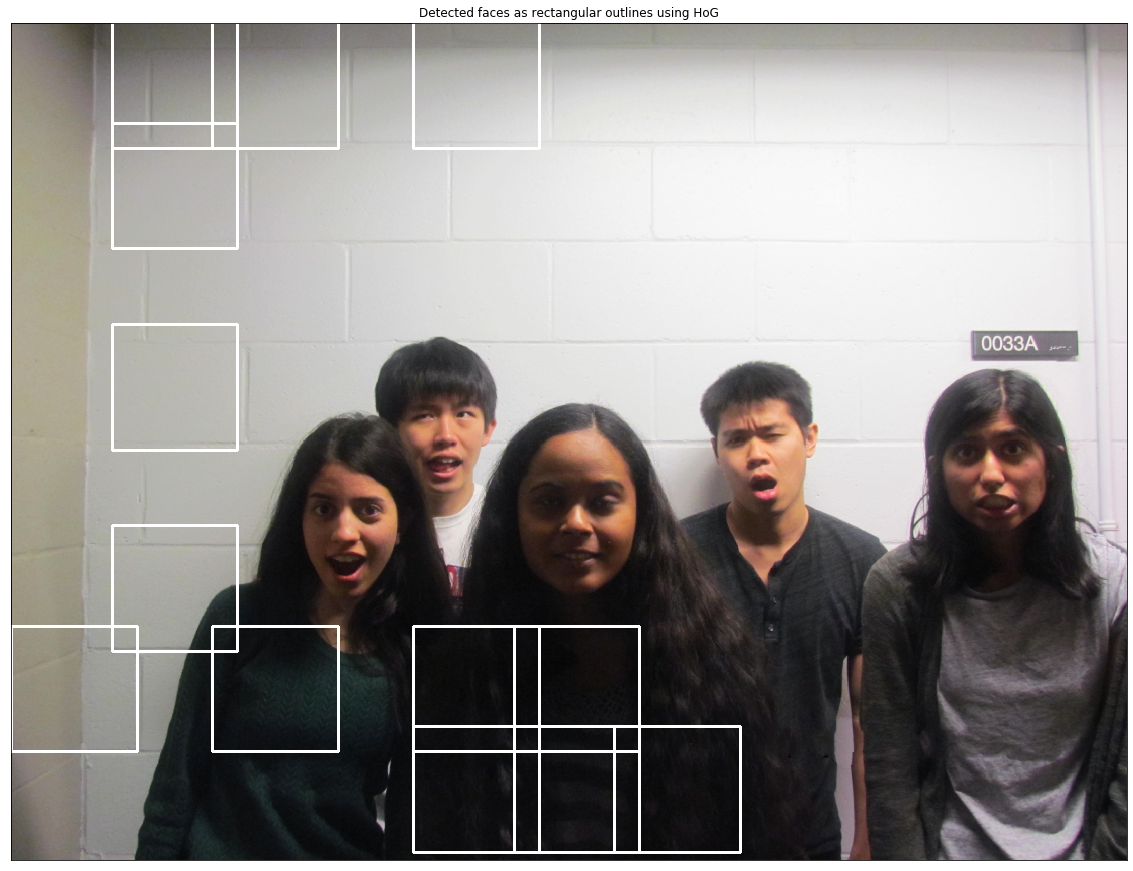

In [43]:
# Threshold
factor_std = 0.95
threshold = np.mean(df_windows["mean_dist_feature_map"]) - factor_std *np.std(df_windows["mean_dist_feature_map"])
threshold_flipped = np.mean(df_windows["mean_dist_feature_map_flipped"]) - factor_std *np.std(df_windows["mean_dist_feature_map"])


# Subset that reach threshold
df_subset = df_windows[np.logical_and(df_windows["mean_dist_feature_map"] < threshold, 
                                      df_windows["mean_dist_feature_map_flipped"] <threshold_flipped)]

test_patch =  cv2.cvtColor(cv2.imread("Images/Group_pic_1.JPG"),cv2.COLOR_BGR2RGB)
test_patch =  cv2.resize(test_patch , (int(test_patch.shape[1]/2),int(test_patch.shape[0]/2)))
# Display detected windows as patches
for i,row in df_subset.iterrows():
    cv2.rectangle(test_patch, (row["x"], row["y"]), 
                  (row["x"]+125, row["y"]+125), 
                  (255,255,255), 2)

plt.figure(figsize=(20,20))
plt.imshow(test_patch)
plt.xticks([])
plt.yticks([])
plt.title("Detected faces as rectangular outlines using HoG")